In [2]:
%load_ext autoreload
%autoreload 2
from imports.networks import *
from imports.data import *
from imports.params import p
import matplotlib.pyplot as plt

# difference plots 14 nov


In [3]:
sw_path = "flamingo_0077/flamingo_0077.hdf5"
data = Data(p, sw_path=sw_path)
filepath = f"{p['base_data_path']}/obs_data_{p_to_filename(p)}_M1e13_rad2Mpc"
data.make_obs_dataset(filepath=filepath)
images = np.load(f"{filepath}.npy")
images = images[:int(len(images)*data.test_size)]
masses = data.soap_file[f"{data.selection_type}/TotalMass"][np.load(f"{filepath}_halo_indices.npy")]
masses = masses[:int(len(masses)*data.test_size)]
resolution = p['resolution']

[[44.3528941  44.28184173]
 [44.27310389 44.13775446]
 [43.83097879 43.53100253]
 [44.13489992 43.90818006]
 [43.94020287 43.68208107]
 [43.909574   43.51371325]
 [43.5305152  43.12817506]
 [42.26829156 41.16064841]
 [41.59280586 40.13229233]
 [41.88731795 41.26623792]
 [44.48969836 44.40822513]
 [44.57611635 44.55745379]
 [44.19701601 43.99437713]
 [44.44727893 44.33295416]
 [44.50209451 44.43288407]
 [43.86523452 43.47899506]
 [44.27425107 44.07022534]
 [43.89933821 43.5810965 ]
 [43.7320577  43.37522281]
 [43.34112086 42.83746557]
 [43.12594831 42.43560659]
 [43.07582739 42.34017542]
 [42.68699365 41.60958371]
 [42.86634428 41.93761137]
 [43.01384715 42.39396534]
 [41.99642704 40.78408939]
 [41.85377941 40.2992947 ]
 [42.29598368 40.99013627]
 [44.4805806  44.41724714]
 [44.22888457 44.08931718]
 [44.17567195 44.03716254]
 [44.08541883 43.84596441]
 [44.03141561 43.66225018]
 [43.41218424 42.76441973]
 [43.39098316 42.91598938]
 [42.88755043 42.23313287]
 [42.86112914 41.81108661]
 

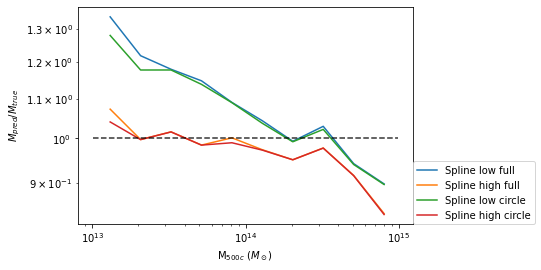

In [4]:
#load models
nnmodel = torch.load(f"{p['base_model_path']}/obs_model_2chan_M13-15_L45.pt")
nnmodel_low = torch.load(f"{p['base_model_path']}/obs_model_low_M13-15_L45.pt")
nnmodel_high = torch.load(f"{p['base_model_path']}/obs_model_high_M13-15_L45.pt")
spl_low = np.load(f"{p['base_model_path']}/spline_fit_low_M13-15_L45.npy", allow_pickle=True)[()]
spl_high = np.load(f"{p['base_model_path']}/spline_fit_high_M13-15_L45.npy", allow_pickle=True)[()]




predictions = np.ndarray((len(data.testy), 7))

#predict with NN
with torch.no_grad():
    predictions[:, 0] = 10**(nnmodel(torch.Tensor(data.testx)).squeeze(1) * data.std_y + data.mean_y)
    predictions[:, 1] = 10**(nnmodel_low(torch.Tensor(data.testx[:,0,:,:].reshape(len(data.testy), 1, 64, 64))).squeeze(1) * data.std_y + data.mean_y)
    predictions[:, 2] = 10**(nnmodel_low(torch.Tensor(data.testx[:,1,:,:].reshape(len(data.testy), 1, 64, 64))).squeeze(1) * data.std_y + data.mean_y)





luminosities_full = np.sum(images, axis=(2, 3), dtype=np.float64)
luminosities_full = np.log10(luminosities_full)

print(luminosities_full)

predictions[:,3] = 10**spl_low(luminosities_full[:,0])
predictions[:,4] = 10**spl_high(luminosities_full[:,1])


X, Y = np.ogrid[:resolution, :resolution]
radius = resolution/2
dist_from_center = np.sqrt((X + 0.5-radius)**2+(Y+0.5-radius)**2)
circle_mask = dist_from_center <= radius

luminosities_circle = np.sum(images[:,:,circle_mask], axis=(2), dtype=np.float64)
luminosities_circle = np.log10(luminosities_circle)
predictions[:,5] = 10**spl_low(luminosities_circle[:,0])
predictions[:,6] = 10**spl_high(luminosities_circle[:,1])



names = ["NN 2chan", "NN low", "NN high", "Spline low full", "Spline high full", "Spline low circle", "Spline high circle"]

for i in range(3, 7):
    nr_bins = 10
    x = np.array([])
    y = np.array([])
    bin_edges = np.logspace(np.log10(np.min(masses)), np.log10(np.max(masses)), nr_bins+1)
    minspread = np.array([])
    maxspread = np.array([])
    for b in range(nr_bins):
        indices = np.logical_and(masses > bin_edges[b], masses < bin_edges[b+1])
        x = np.append(x, np.mean([bin_edges[b], bin_edges[b+1]]))
        y = np.append(y, np.median((predictions[:,i]/masses)[indices]))
    #     minspread = np.append(minspread, np.min((predictions[:,i]/masses)[indices]))
    #     maxspread = np.append(maxspread, np.max((predictions[:,i]/masses)[indices]))
    # plt.plot(x, minspread, label=names[i])
    # plt.plot(x, maxspread, label=names[i])
    plt.plot(x, y, label=names[i])
plt.hlines(1.0, np.min(masses), np.max(masses), colors="black", linestyles="dashed", alpha=0.8)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("M$_{500c}$ $(M_\odot)$")
plt.ylabel("$M_{pred} / M_{true}$")
plt.legend(loc=(1, 0))
plt.show()



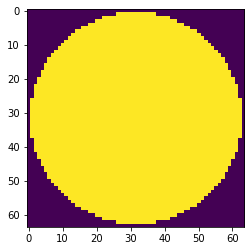

In [17]:
# circle_mask = np.zeros(resolution, resolution)
X, Y = np.ogrid[:resolution, :resolution]
radius = resolution/2
dist_from_center = np.sqrt((X + 0.5-radius)**2+(Y+0.5-radius)**2)
plt.imshow(dist_from_center<=radius)


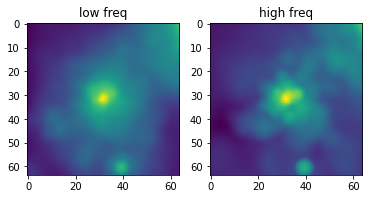

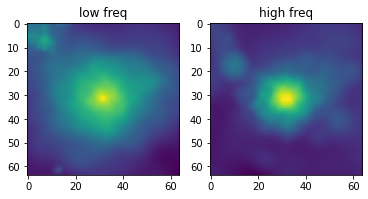

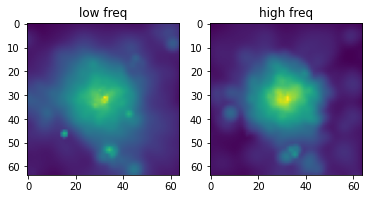

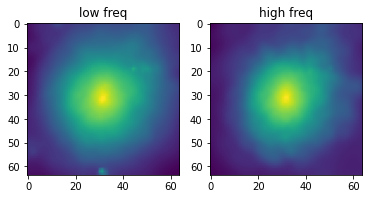

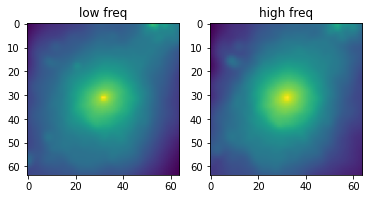

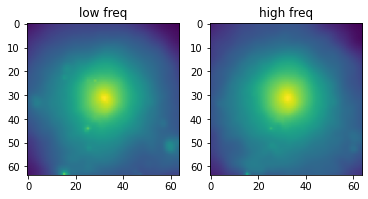

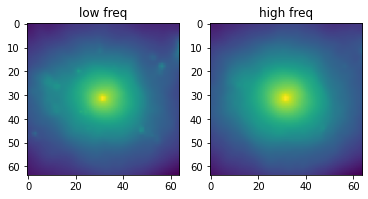

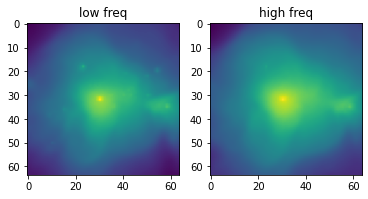

In [54]:
mass_sort = np.argsort(masses)
for i in mass_sort[1::50]:
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(np.log10(images[i,0,:,:]))
    axs[0].set_title("low freq")
    axs[1].imshow(np.log10(images[i,1,:,:]))
    axs[1].set_title("high freq")
    # plt.title(f"Mass: {np.log10(masses[i]):.01f}")
    plt.show()

# data exploration


In [3]:
soap_path = "halo_properties_0077.hdf5"
data = Data(p, soap_path=soap_path)

[1.00126345e+11 1.62548522e+11 2.63886813e+11 4.28402849e+11
 6.95483792e+11 1.12907210e+12 1.83297414e+12 2.97571272e+12
 4.83087349e+12 7.84260473e+12 1.27319519e+13 2.06694848e+13
 3.35555464e+13 5.44752181e+13 8.84369263e+13 1.43571521e+14
 2.33078903e+14 3.78388238e+14 6.14288367e+14 9.97256679e+14]


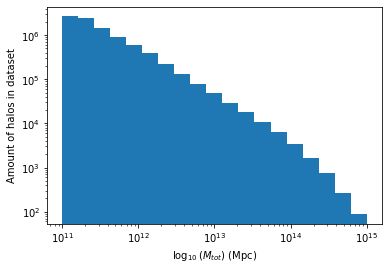

In [23]:
mass = data.soap_file[f"{p['selection_type']}/TotalMass"][:]
mass = mass[np.logical_and(np.logical_and(mass > 1e11, mass !=0), mass < 1e15)]
bins = np.logspace(np.log10(np.min(mass)), np.log10(np.max(mass)), 20)
print(bins)
ret = plt.hist(mass, bins=bins)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Amount of halos in dataset")
plt.xlabel("$\log_{10}(M_{tot})$ (Mpc)")
plt.show()

In [24]:
print(ret)

(array([2.658175e+06, 2.436279e+06, 1.443613e+06, 8.889650e+05,
       5.937730e+05, 3.860400e+05, 2.274540e+05, 1.318370e+05,
       7.770900e+04, 4.786600e+04, 2.939100e+04, 1.817200e+04,
       1.072000e+04, 6.328000e+03, 3.430000e+03, 1.670000e+03,
       7.550000e+02, 2.690000e+02, 8.800000e+01]), array([1.00126345e+11, 1.62548522e+11, 2.63886813e+11, 4.28402849e+11,
       6.95483792e+11, 1.12907210e+12, 1.83297414e+12, 2.97571272e+12,
       4.83087349e+12, 7.84260473e+12, 1.27319519e+13, 2.06694848e+13,
       3.35555464e+13, 5.44752181e+13, 8.84369263e+13, 1.43571521e+14,
       2.33078903e+14, 3.78388238e+14, 6.14288367e+14, 9.97256679e+14]), <BarContainer object of 19 artists>)
